# A Simple PyTorch model


In [1]:
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

DATA_DIR = Path.home() / "data"

In [2]:
class LeNet(nn.Module):
  def __init__(self):
    super(LeNet, self).__init__()
    # 1 个输入图片通道 (black & white), 6 个输出通道, 3x3 方形卷积核
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.conv2 = nn.Conv2d(6, 16, 3)
    # 仿射操作: y = Wx + b
    self.fc1 = nn.Linear(16 * 6 * 6, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))  # 2x2 window
    x = F.max_pool2d(F.relu(self.conv2(x)), 2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # 除批次维度外的所有维度
    num_features = 1
    for s in size:
      num_features *= s
    return num_features


In [3]:
net = LeNet()
print(net)

input = torch.rand(1, 1, 32, 32)
print(f"\nImage batch shape: {input.shape}")

output = net(input)
print(f"\nRaw output: {output}")
print(output.shape)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Image batch shape: torch.Size([1, 1, 32, 32])

Raw output: tensor([[ 0.1091,  0.1127, -0.0114,  0.0696,  0.0188, -0.1038,  0.0980,  0.0460,
          0.0095,  0.0259]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


In [4]:
%matplotlib inline
import torchvision
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose(
  [
    # 通过 Pillow 转换图片为 PyTorch Tensor
    transforms.ToTensor(),
    # 对张量进行归一化处理，均值和标准差均为 (0.5, 0.5, 0.5)
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ]
)

In [6]:
trainset = torchvision.datasets.CIFAR10(
  root=DATA_DIR, train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
  root=DATA_DIR, train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

Files already downloaded and verified
Files already downloaded and verified


 bird  bird   car  deer


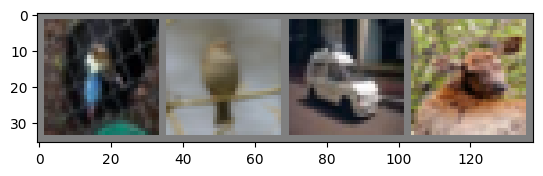

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s" % classes[labels[j]] for j in range(4)))

In [8]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    # 仿射操作: y = Wx + b
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x


net = Net()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 1):
    # get the inputs
    inputs, labels = data

    # zero the perameter gradients
    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 0:
      print("[%d, %5d] loss: %.3f" % (epoch + 1, i, running_loss / 2000))
      running_loss = 0.0

print("Finished Training")

[1,  2000] loss: 2.191
[1,  4000] loss: 1.841
[1,  6000] loss: 1.669
[1,  8000] loss: 1.580
[1, 10000] loss: 1.527
[1, 12000] loss: 1.475
[2,  2000] loss: 1.406
[2,  4000] loss: 1.363
[2,  6000] loss: 1.345
[2,  8000] loss: 1.318
[2, 10000] loss: 1.296
[2, 12000] loss: 1.260
Finished Training


In [11]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print("Accuracy of the network on the 10000 test images: %d %%" % (100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
